In [1]:
import torch
import torch.nn as nn
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [3]:
class MCDataset_log10energy(Dataset):
    def __init__(self, npdata):
        para_need = {
            "Matrix","pred_log10energy","log10Energy"
        }
        self.MCdata = {key: npdata[key] for key in para_need}

    def __len__(self):
        return len(self.MCdata["pred_log10energy"])

    def __getitem__(self, index):
        Matrix = self.MCdata["Matrix"][index].astype(np.float32)
        pred_log10energy = np.array(self.MCdata["pred_log10energy"][index]).astype(np.float32)
        log10energy = np.array(self.MCdata["log10Energy"][index]).astype(np.float32)
        return (
            torch.from_numpy(Matrix),
            torch.from_numpy(pred_log10energy),
            torch.from_numpy(log10energy),
        )


In [4]:
npdata = np.load("/home2/hky/github/Gamma_Energy/AllSky_orginData/Data/train_cuted_data_CNN.npz")
train_index,test_index = train_test_split(range(len(npdata["nch"])),random_state=42,test_size=0.1)
npdata_train = {key: npdata[key][train_index] for key in npdata}
npdata_test = {key: npdata[key][test_index] for key in npdata}

MCdataset_train = MCDataset_log10energy(npdata_train)
MCdataset_test = MCDataset_log10energy(npdata_test)

train_dataloader = DataLoader(MCdataset_train,batch_size=512,shuffle=True)
test_dataloader = DataLoader(MCdataset_test,batch_size=512,shuffle=True)

In [5]:
for i in train_dataloader:
    print(i[0].shape)
    break

torch.Size([512, 2, 32, 32])


In [6]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)


In [27]:
class NeuralNetworkVGG(nn.Module):
    def __init__(self):
        super(NeuralNetworkVGG, self).__init__()

        self.flatten = nn.Flatten()
        self.ReLu = nn.ReLU()
        self.Dropout = nn.Dropout(0.5)

        self.conv_blks = []
        in_channels = 1
        conv_arch = ((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))
        for num_convs, out_channels in conv_arch:
            self.conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
            in_channels = out_channels

        self.linear1 = nn.Linear(out_channels*1*1,128)
        self.linear2 = nn.Linear(128,128)
        self.linear3 = nn.Linear(128,1)
        self.linear4 = nn.Linear(2,1)
        self.Seq = nn.Sequential(*self.conv_blks,self.flatten,self.linear1,self.ReLu,self.Dropout,self.linear2,self.ReLu,self.Dropout,self.linear3)
    
    def forward(self,Matrix,pred_log10energy):
        # print(Matrix.shape)
        X = self.Seq(Matrix)
        pred_log10energy = pred_log10energy.view(-1,1)
        X = torch.cat([X,pred_log10energy],1)
        # print(X)
        X = self.linear4(X)
        return X.view(-1)


In [28]:
net = NeuralNetworkVGG().to(device)

In [29]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)

In [30]:
def train(dataloader, net, loss_fn, optimizer):
    net.train()
    pred_list = list()
    orgin_list = list()
    for batch, (
        Matrix,
        pred_log10energy,
        log10energy,
    ) in enumerate(dataloader):
        Matrix, pred_log10energy, log10energy = Matrix[:,0,:,:].reshape(-1,1,32,32).to(device), pred_log10energy.to(device), log10energy.to(device)

        pred = net(Matrix,pred_log10energy)
        pred_list.append(pred)
        orgin_list.append(log10energy)
        loss = loss_fn(pred,log10energy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    pred_list = torch.cat(pred_list)
    orgin_list = torch.cat(orgin_list)
    root_mean_squared_error = np.sqrt(loss_fn(pred_list,orgin_list).item())
    return root_mean_squared_error


def test(dataloader, net, loss_fn):
    net.eval()
    pred_list = list()
    orgin_list = list()
    for batch, (
        Matrix,
        pred_log10energy,
        log10energy,
    ) in enumerate(dataloader):
        Matrix, pred_log10energy, log10energy = Matrix[:,0,:,:].reshape(-1,1,32,32).to(device), pred_log10energy.to(device), log10energy.to(device)

        pred = net(Matrix,pred_log10energy)
        pred_list.append(pred)
        orgin_list.append(log10energy)
    pred_list = torch.cat(pred_list)
    orgin_list = torch.cat(orgin_list)
    root_mean_squared_error = np.sqrt(loss_fn(pred_list,orgin_list).item())
    return root_mean_squared_error


In [31]:
class Animator:
    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(8, 6),
    ):
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        self.legend = legend
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xlim = xlim
        self.ylim = ylim
        self.xscale = xscale
        self.yscale = yscale
        self.fmts = fmts
        self.X, self.Y = None, None

    def add(self,x,y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt,label in zip(self.X, self.Y, self.fmts, self.legend):
            self.axes[0].plot(x, y, fmt,label=label)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        plt.xscale(self.xscale)
        plt.yscale(self.yscale)
        plt.legend(loc=1)
        display.display(self.fig)
        display.clear_output(wait=True)

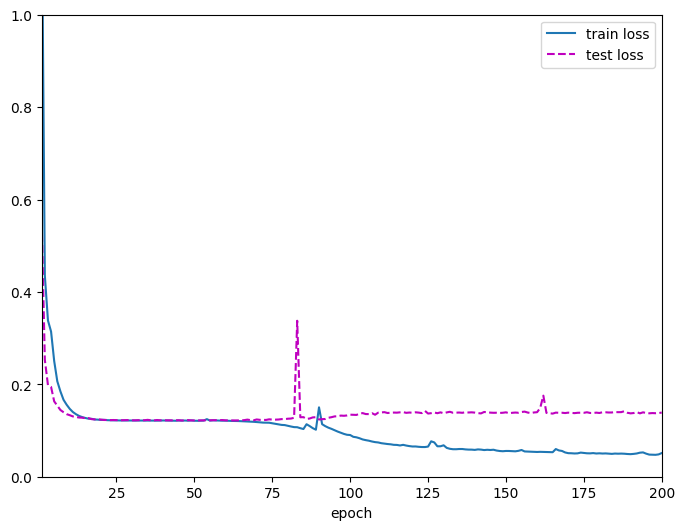

In [32]:
num_epochs = 200
animator = Animator(xlabel="epoch",xlim=[1,num_epochs],ylim=[0,1],legend=["train loss","test loss"])
for epochs in range(num_epochs):
    root_mean_squared_error_train = train(train_dataloader, net, loss_fn, optimizer)
    root_mean_squared_error_test = test(test_dataloader, net, loss_fn)
    animator.add(epochs+1,[root_mean_squared_error_train,root_mean_squared_error_test])
    # print(epochs,f"{root_mean_squared_error_train:.3f}",f"{root_mean_squared_error_test:.3f}")

In [33]:
test(test_dataloader, net, loss_fn)

0.13888190710546536

In [34]:

net.eval()
pred_list = list()
orgin_list = list()
for batch, (
    Matrix,
    pred_log10energy,
    log10energy,
) in enumerate(test_dataloader):
    Matrix, pred_log10energy, log10energy = Matrix.to(device), pred_log10energy.to(device), log10energy.to(device)

    pred_list.append(pred_log10energy)
    orgin_list.append(log10energy)
pred_list = torch.cat(pred_list)
orgin_list = torch.cat(orgin_list)
root_mean_squared_error = np.sqrt(loss_fn(pred_list,orgin_list).item())
print(root_mean_squared_error)

0.12325808396871378
